In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import pickle
import numpy as np

In [4]:
partidos = pd.read_csv('../Data/partidos.csv')
puntuacion = pd.read_csv('../Data/puntuacion.csv')

# Preparacion de los datos

In [5]:
partidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752 entries, 0 to 1751
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sem.           1752 non-null   int64  
 1   Día            1752 non-null   object 
 2   Fecha          1752 non-null   object 
 3   Hora           1752 non-null   object 
 4   Local          1752 non-null   object 
 5   xG_l           1752 non-null   float64
 6   xG_v           1752 non-null   float64
 7   Visitante      1752 non-null   object 
 8   Asistencia     1748 non-null   float64
 9   Sedes          1752 non-null   object 
 10  Árbitro        1752 non-null   object 
 11  Liga           1752 non-null   object 
 12  Gol_local      1752 non-null   int64  
 13  Gol_visitante  1752 non-null   int64  
 14  resultado      1752 non-null   object 
dtypes: float64(3), int64(3), object(9)
memory usage: 205.4+ KB


In [6]:
puntuacion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17760 entries, 0 to 17759
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Club    17760 non-null  object 
 1   Elo     17760 non-null  float64
 2   Fecha   17760 non-null  object 
dtypes: float64(1), object(2)
memory usage: 416.4+ KB


De los dataset solo se usara la semana, fecha, nombres de equipos, resultado y puntuacion Elo

In [ ]:
partidos = partidos[['Fecha','Local','Visitante','resultado']]

In [ ]:
Elo_local = pd.merge(partidos, puntuacion, left_on=['Local', 'Fecha'], right_on=['Club', 'Fecha'], how = 'left')
data = pd.merge(Elo_local, puntuacion, left_on=['Visitante', 'Fecha'], right_on=['Club', 'Fecha'], how = 'left')
data.drop(['Club_x' , 'Club_y', 'Fecha'], axis = 1, inplace = True)
data.rename(columns={'Elo_x': 'Elo_local', 'Elo_y': 'Elo_visitante'}, inplace = True)

In [ ]:
data.head(30)

,Local,Visitante,resultado,Elo_local,Elo_visitante
0,1,73,0.0,1619.363647,1623.332520
1,81,90,0.0,1768.199707,1661.928345
2,75,35,1.0,1788.485352,1666.839722
3,44,56,1.0,1576.261108,1649.566406
4,5,74,0.0,1696.694458,1906.480347
5,19,70,0.0,1659.398560,1670.765259
6,91,10,0.0,1771.594360,1739.277588
7,34,8,1.0,1651.055420,1862.138672
8,23,0,2.0,1634.786743,1598.595215
9,6,37,2.0,1846.306274,1620.577881


In [ ]:
LE = LabelEncoder()
data['Local'] = LE.fit_transform(data['Local'])
data['Visitante'] = LE.transform(data['Visitante'])
OE = OrdinalEncoder(categories=[['D', 'E', 'V']])
data['resultado'] = OE.fit_transform(data[['resultado']])

In [ ]:
data.head(20)

,Local,Visitante,resultado,Elo_local,Elo_visitante
0,1,73,0.0,1619.363647,1623.332520
1,81,90,0.0,1768.199707,1661.928345
2,75,35,1.0,1788.485352,1666.839722
3,44,56,1.0,1576.261108,1649.566406
4,5,74,0.0,1696.694458,1906.480347
5,19,70,0.0,1659.398560,1670.765259
6,91,10,0.0,1771.594360,1739.277588
7,34,8,1.0,1651.055420,1862.138672
8,23,0,2.0,1634.786743,1598.595215
9,6,37,2.0,1846.306274,1620.577881


In [ ]:
X = data.drop(['resultado'], axis = 1)
y = data['resultado']

<Axes: >

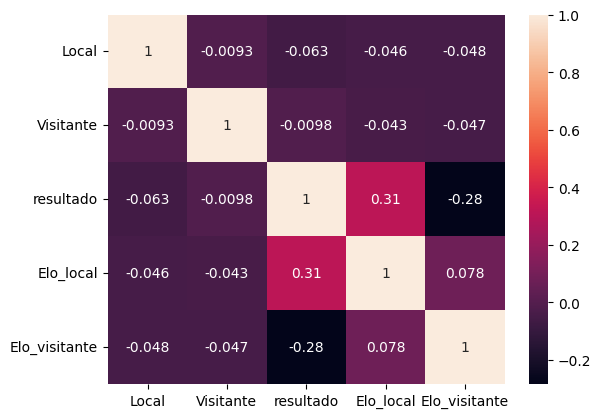

In [ ]:
sns.heatmap(data.corr(), annot = True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [ ]:
def evaluacion(y_test, y_pred, X, y, model):
  print('Reporte de clasifiación')
  print(classification_report(y_test, y_pred))

  Cross_validation = cross_val_score(model, X, y, cv = 5).mean()
  print(f"Accuracy: {Cross_validation*100:.2f} %")
  return np.round(Cross_validation*100, 2)

# Regresion logistica

In [ ]:
def objective_lr(trial, X, y):
  params = {
  "C": trial.suggest_float("C", 1e-3, 1)}
  model = LogisticRegression(**params)
  accuracy = cross_val_score(model, X, y, cv = 5).mean()
  return accuracy

In [ ]:
study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(lambda trial: objective_lr(trial, X, y), n_trials=100)

[I 2024-09-22 03:37:17,733] A new study created in memory with name: no-name-bfa07b61-f24a-48bf-9d86-246e8a7c7fe9
[I 2024-09-22 03:37:17,976] Trial 0 finished with value: 0.5365307285307286 and parameters: {'C': 0.7193874898493885}. Best is trial 0 with value: 0.5365307285307286.
[I 2024-09-22 03:37:18,196] Trial 1 finished with value: 0.5365307285307286 and parameters: {'C': 0.8122606594475985}. Best is trial 0 with value: 0.5365307285307286.
[I 2024-09-22 03:37:18,390] Trial 2 finished with value: 0.5365307285307286 and parameters: {'C': 0.6399431851268597}. Best is trial 0 with value: 0.5365307285307286.
[I 2024-09-22 03:37:18,585] Trial 3 finished with value: 0.5365307285307286 and parameters: {'C': 0.7741571663880834}. Best is trial 0 with value: 0.5365307285307286.
[I 2024-09-22 03:37:18,774] Trial 4 finished with value: 0.5365307285307286 and parameters: {'C': 0.41865389920275364}. Best is trial 0 with value: 0.5365307285307286.
[I 2024-09-22 03:37:18,955] Trial 5 finished with 

In [ ]:
lr = LogisticRegression(**study_lr.best_params)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
Accuracy_lr = evaluacion(y_test, y_pred, X, y, lr)
Accuracy_lr

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Reporte de clasifiación
              precision    recall  f1-score   support

         0.0       0.55      0.56      0.56       174
         1.0       0.00      0.00      0.00       140
         2.0       0.49      0.80      0.60       212

    accuracy                           0.51       526
   macro avg       0.34      0.45      0.39       526
weighted avg       0.38      0.51      0.43       526

Accuracy: 53.65 %


53.65

# Gradient Boosting Classifier

In [ ]:
def objective_gbc(trial, X, y):
  params = {
      "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1),
      "max_depth": trial.suggest_int("max_depth", 1, 10),
      "min_samples_split": trial.suggest_float("min_samples_split", 0.05, 1.0)
  }

  model = GradientBoostingClassifier(**params)
  accuracy = cross_val_score(model, X, y, cv = 5).mean()
  return accuracy

In [ ]:
study_gbc = optuna.create_study(direction='maximize')
study_gbc.optimize(lambda trial: objective_gbc(trial, X, y), n_trials=100)

[I 2024-09-22 03:37:52,540] A new study created in memory with name: no-name-1bd65a92-0ee5-4c8f-bbcf-d9b4913b9215
[I 2024-09-22 03:38:01,668] Trial 0 finished with value: 0.45658282458282456 and parameters: {'learning_rate': 0.33165323740289804, 'max_depth': 8, 'min_samples_split': 0.33908673352624163}. Best is trial 0 with value: 0.45658282458282456.
[I 2024-09-22 03:38:07,860] Trial 1 finished with value: 0.4771542531542532 and parameters: {'learning_rate': 0.21713385700194585, 'max_depth': 5, 'min_samples_split': 0.13432384713985962}. Best is trial 1 with value: 0.4771542531542532.
[I 2024-09-22 03:38:10,834] Trial 2 finished with value: 0.5108294668294668 and parameters: {'learning_rate': 0.32056257955313944, 'max_depth': 1, 'min_samples_split': 0.2600924749417814}. Best is trial 2 with value: 0.5108294668294668.
[I 2024-09-22 03:38:19,506] Trial 3 finished with value: 0.43490923890923894 and parameters: {'learning_rate': 0.8849573446158556, 'max_depth': 10, 'min_samples_split': 0.

In [ ]:
gbc = GradientBoostingClassifier(**study_gbc.best_params)
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)
Accuracy_gbc = evaluacion(y_test, y_pred, X, y, gbc)
Accuracy_gbc

Reporte de clasifiación
              precision    recall  f1-score   support

         0.0       0.55      0.56      0.55       174
         1.0       0.38      0.09      0.14       140
         2.0       0.51      0.76      0.61       212

    accuracy                           0.52       526
   macro avg       0.48      0.47      0.44       526
weighted avg       0.49      0.52      0.47       526

Accuracy: 52.28 %


52.28

# Kneighbors Classifier

In [ ]:
def objective_KN(trial, X, y):
  params = {
    'n_neighbors': trial.suggest_int('n_neighbors', 1, 10),
    'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
    'p': trial.suggest_int('p', 1, 2)
  }

  model = KNeighborsClassifier(**params)
  accuracy = cross_val_score(model, X, y, cv = 5).mean()
  return accuracy

In [ ]:
study_KN = optuna.create_study(direction='maximize')
study_KN.optimize(lambda trial: objective_KN(trial, X, y), n_trials=100)

[I 2024-09-22 03:44:07,912] A new study created in memory with name: no-name-86ca2a62-0f17-4cc7-b146-ea9aa1fd4dbd
[I 2024-09-22 03:44:07,969] Trial 0 finished with value: 0.484001628001628 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.484001628001628.
[I 2024-09-22 03:44:08,024] Trial 1 finished with value: 0.4657387057387058 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.484001628001628.
[I 2024-09-22 03:44:08,150] Trial 2 finished with value: 0.40753764753764754 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.484001628001628.
[I 2024-09-22 03:44:08,285] Trial 3 finished with value: 0.4468929588929589 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.484001628001628.
[I 2024-09-22 03:44:08,418] Trial 4 finished with value: 0.4657370777370778 and parameters: {'n_neighbors': 6, 'weights': 'unif

In [ ]:
KN = KNeighborsClassifier(**study_KN.best_params)
KN.fit(X_train, y_train)
y_pred = KN.predict(X_test)
Accuracy_KN = evaluacion(y_test, y_pred, X, y, KN)
Accuracy_KN

Reporte de clasifiación
              precision    recall  f1-score   support

         0.0       0.50      0.47      0.48       174
         1.0       0.30      0.19      0.23       140
         2.0       0.51      0.67      0.58       212

    accuracy                           0.47       526
   macro avg       0.44      0.44      0.43       526
weighted avg       0.45      0.47      0.45       526

Accuracy: 49.20 %


49.2

# Random Forest Classifier

In [ ]:
def objective_rfc(trial, X, y):
  params = {
    'n_estimators': trial.suggest_int('n_estimators', 10,100),
    'max_depth': trial.suggest_int('max_depth', 1,20),
    'min_samples_split': trial.suggest_int('min_samples_split', 2, 10)

  }

  model = RandomForestClassifier(**params)
  accuracy = cross_val_score(model, X, y, cv = 5).mean()
  return accuracy

In [ ]:
study_rfc = optuna.create_study(direction='maximize')
study_rfc.optimize(lambda trial: objective_rfc(trial, X, y), n_trials=100)

[I 2024-09-22 03:44:16,346] A new study created in memory with name: no-name-98f9a669-fe48-46db-b42e-5f41b5a07622
[I 2024-09-22 03:44:17,205] Trial 0 finished with value: 0.5131330891330892 and parameters: {'n_estimators': 50, 'max_depth': 2, 'min_samples_split': 6}. Best is trial 0 with value: 0.5131330891330892.
[I 2024-09-22 03:44:17,629] Trial 1 finished with value: 0.4805649165649166 and parameters: {'n_estimators': 13, 'max_depth': 11, 'min_samples_split': 8}. Best is trial 0 with value: 0.5131330891330892.
[I 2024-09-22 03:44:18,433] Trial 2 finished with value: 0.4851477411477411 and parameters: {'n_estimators': 77, 'max_depth': 1, 'min_samples_split': 6}. Best is trial 0 with value: 0.5131330891330892.
[I 2024-09-22 03:44:19,229] Trial 3 finished with value: 0.47487667887667884 and parameters: {'n_estimators': 39, 'max_depth': 12, 'min_samples_split': 9}. Best is trial 0 with value: 0.5131330891330892.
[I 2024-09-22 03:44:20,902] Trial 4 finished with value: 0.4914171754171754

In [ ]:
rfc = RandomForestClassifier(**study_rfc.best_params)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
Accuracy_rfc = evaluacion(y_test, y_pred, X, y, rfc)
Accuracy_rfc

Reporte de clasifiación
              precision    recall  f1-score   support

         0.0       0.55      0.47      0.50       174
         1.0       1.00      0.01      0.01       140
         2.0       0.48      0.85      0.61       212

    accuracy                           0.50       526
   macro avg       0.68      0.44      0.38       526
weighted avg       0.64      0.50      0.42       526

Accuracy: 51.77 %


51.77

# LGB

In [ ]:
def objective_lgbm(trial, X, y):
    params = {
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    model = lgb.LGBMClassifier(**params)
    accuracy = cross_val_score(model, X, y, cv = 5).mean()
    return accuracy

In [ ]:
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(lambda trial: objective_lgbm(trial, X, y), n_trials=100)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
lgbm = lgb.LGBMClassifier(**study_lgbm.best_params)
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)
Accuracy_lgb = evaluacion(y_test, y_pred, X, y, lgbm)
Accuracy_lgb

[LightGBM] [Warning] feature_fraction is set=0.8775759813158122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8775759813158122
[LightGBM] [Warning] lambda_l2 is set=3.189999558814102, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.189999558814102
[LightGBM] [Warning] lambda_l1 is set=9.952567552382991, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.952567552382991
[LightGBM] [Warning] bagging_fraction is set=0.5633386122686733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5633386122686733
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8775759813158122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8775759813158122
[LightGBM] [Warning] lambda_l2 is set=3.189999558814102, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.189999558814102
[LightGBM] [Warning] lambda_l1 is set=9.95

52.62

# Resumen de modelos

In [ ]:
Nombres = ['Regresion logistica', 'GradientBoosting', 'KNeighbors','Random Forest', 'LGB']
valores = [Accuracy_lr, Accuracy_gbc,Accuracy_KN,Accuracy_rfc, Accuracy_lgb]
resultados = {'Modelo': Nombres, 'Accuracy': valores}
res = pd.DataFrame(resultados)
res= res.sort_values(by = ['Accuracy'])
res

,Modelo,Accuracy
2,KNeighbors,49.20
3,Random Forest,51.77
1,GradientBoosting,52.28
4,LGB,52.62
0,Regresion logistica,53.65


<BarContainer object of 5 artists>

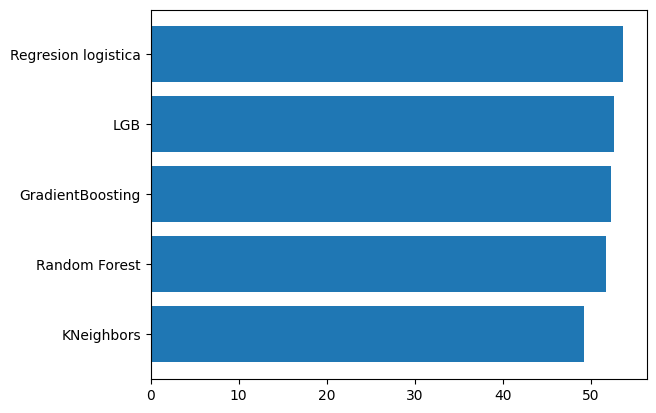

In [ ]:
plt.barh(y = res['Modelo'], width = res['Accuracy'])

# Guardar modelo

In [ ]:
nombre = '../Modelo/model.pkl'
pickle.dump(lr, open(nombre, 'wb'))

In [ ]:
model = pickle.load(open(nombre, 'rb'))

In [ ]:
nombre = '../Modelo/LE.pkl'
pickle.dump(LE, open(nombre, 'wb'))
nombre = '../Modelo/OE.pkl'
pickle.dump(OE, open(nombre, 'wb'))